Using device: cuda


C:\Users\thiru\AppData\Local\Temp\ipykernel_25008\3996552045.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = data.groupby("Sentence #", group_keys=False).apply(


Epoch 1/3 | Train Loss: 0.8042 | Val Loss: 0.5466
Epoch 2/3 | Train Loss: 0.4192 | Val Loss: 0.4741
Epoch 3/3 | Train Loss: 0.2965 | Val Loss: 0.4637
              precision    recall  f1-score   support

       B-art     0.3333    0.0208    0.0392        96
       B-eve     0.7105    0.3462    0.4655        78
       B-geo     0.8763    0.8943    0.8852      7377
       B-gpe     0.9364    0.9323    0.9344      3176
       B-nat     0.7500    0.6000    0.6667        40
       B-org     0.7729    0.7528    0.7627      3907
       B-per     0.8233    0.8230    0.8231      3362
       B-tim     0.9341    0.9401    0.9371      4104
       I-art     0.5000    0.0116    0.0227        86
       I-eve     0.5417    0.1857    0.2766        70
       I-geo     0.8290    0.7700    0.7984      1448
       I-gpe     0.8500    0.5152    0.6415        33
       I-nat     0.7500    0.4286    0.5455        14
       I-org     0.7773    0.8469    0.8106      3252
       I-per     0.8515    0.8744    0.

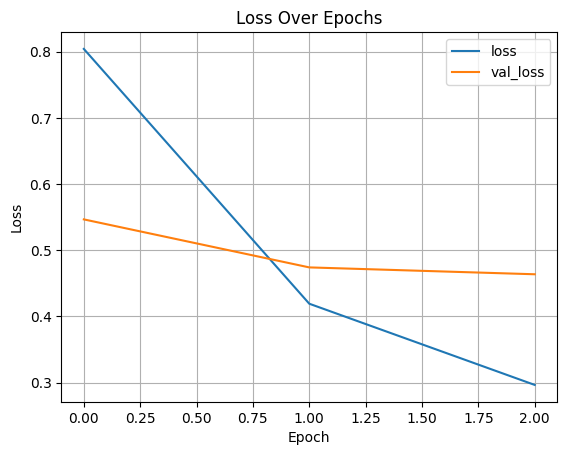

Name: THIRUMALAI K                
Register Number:  212224240176    
Word            True       Pred
----------------------------------------
Palestinian     B-gpe      B-gpe
officials       O          B-gpe
say             O          B-tim
two             O          B-tim
Palestinians    B-gpe      B-gpe
have            O          B-gpe
been            O          B-gpe
killed          O          B-tim
in              O          B-tim
an              O          B-geo
accidental      O          B-tim
explosion       O          B-tim
in              O          B-tim
a               O          B-geo
West            B-org      B-org
Bank            I-org      I-org
refugee         O          I-org
camp            O          B-tim
.               O          B-org


In [2]:
# 🔁 All Imports
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 💻 Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 📥 Load and prepare data
data = pd.read_csv("ner_dataset.csv", encoding="latin1").ffill()
words = list(data["Word"].unique())
tags = list(data["Tag"].unique())

if "ENDPAD" not in words:
    words.append("ENDPAD")

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

# 📋 Group words by sentences
class SentenceGetter:
    def __init__(self, data):
        self.grouped = data.groupby("Sentence #", group_keys=False).apply(
            lambda s: [(w, t) for w, t in zip(s["Word"], s["Tag"])]
        )
        self.sentences = list(self.grouped)

getter = SentenceGetter(data)
sentences = getter.sentences

# 🧠 Encode sentences
X = [[word2idx[w] for w, t in s] for s in sentences]
y = [[tag2idx[t] for w, t in s] for s in sentences]

# 📏 Padding sequences
max_len = 50
X_pad = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True, padding_value=word2idx["ENDPAD"])
y_pad = pad_sequence([torch.tensor(seq) for seq in y], batch_first=True, padding_value=tag2idx["O"])
X_pad = X_pad[:, :max_len]
y_pad = y_pad[:, :max_len]

# 🔀 Split data
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=1)

# 📦 Dataset class
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "input_ids": self.X[idx],
            "labels": self.y[idx]
        }

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=32)

# 🤖 BiLSTM Model definition
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(BiLSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx["ENDPAD"])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, input_ids):
        emb = self.embedding(input_ids)                      # Shape: (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(emb)                         # Shape: (batch_size, seq_len, hidden_dim)
        logits = self.fc(lstm_out)                           # Shape: (batch_size, seq_len, tagset_size)
        return logits

# 🛠 Initialize model, loss, and optimizer
model = BiLSTMTagger(vocab_size=len(word2idx) + 1, tagset_size=len(tag2idx)).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=tag2idx["O"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 🔁 Training & Evaluation
def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)

            loss = loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids)
                loss = loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

def evaluate_model(model, test_loader, X_test, y_test):
    model.eval()
    true_tags, pred_tags = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=-1)
            for i in range(len(labels)):
                for j in range(len(labels[i])):
                    if labels[i][j] != tag2idx["O"]:
                        true_tags.append(idx2tag[labels[i][j].item()])
                        pred_tags.append(idx2tag[preds[i][j].item()])
    print(classification_report(true_tags, pred_tags, digits=4))

# 🏃‍♂️ Train & Evaluate
train_losses, val_losses = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3)
evaluate_model(model, test_loader, X_test, y_test)

# 📊 Plot loss curve
print('Name:  THIRUMALAI K               ')
print('Register Number:  212224240176    ')
history_df = pd.DataFrame({"loss": train_losses, "val_loss": val_losses})
history_df.plot(title="Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 🔍 Inference and prediction on sample
i = 125
model.eval()
sample = X_test[i].unsqueeze(0).to(device)
output = model(sample)
preds = torch.argmax(output, dim=-1).squeeze().cpu().numpy()
true = y_test[i].numpy()

print('Name: THIRUMALAI K                ')
print('Register Number:  212224240176    ')
print("{:<15} {:<10} {}\n{}".format("Word", "True", "Pred", "-" * 40))
for w_id, true_tag, pred_tag in zip(X_test[i], y_test[i], preds):
    if w_id.item() != word2idx["ENDPAD"]:
        word = words[w_id.item() - 1]
        true_label = tags[true_tag.item()]
        pred_label = tags[pred_tag]
        print(f"{word:<15} {true_label:<10} {pred_label}")